# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.fft import dctn, idctn, dct, idct
import seaborn as sns
import os
from scipy import datasets
from skimage.color import rgb2ycbcr, ycbcr2rgb
import imageio

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

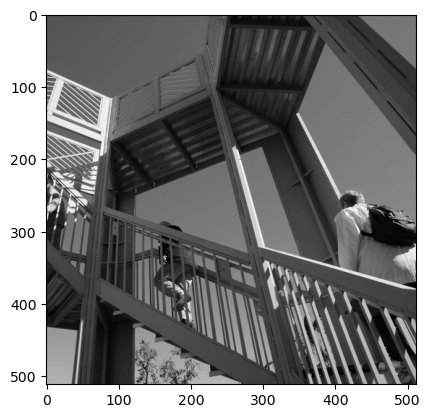

In [51]:
# https://docs.scipy.org/doc/scipy-1.16.1/reference/generated/scipy.datasets.ascent.html
X = scipy.datasets.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

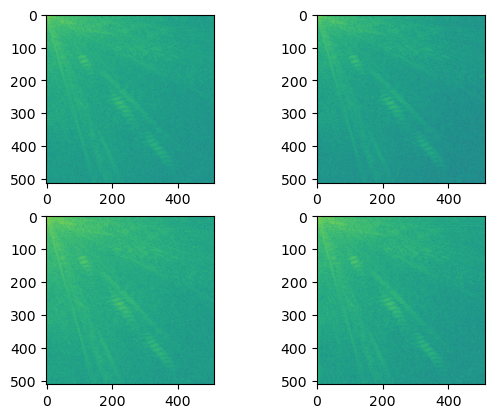

In [52]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

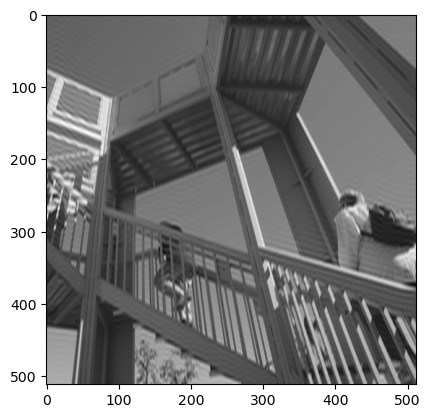

In [53]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

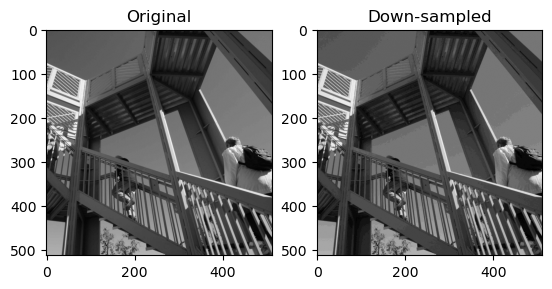

In [54]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

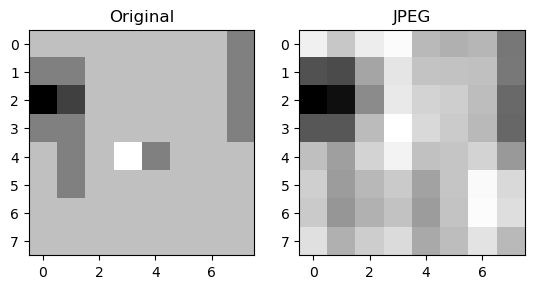

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [55]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr).

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

Ex1

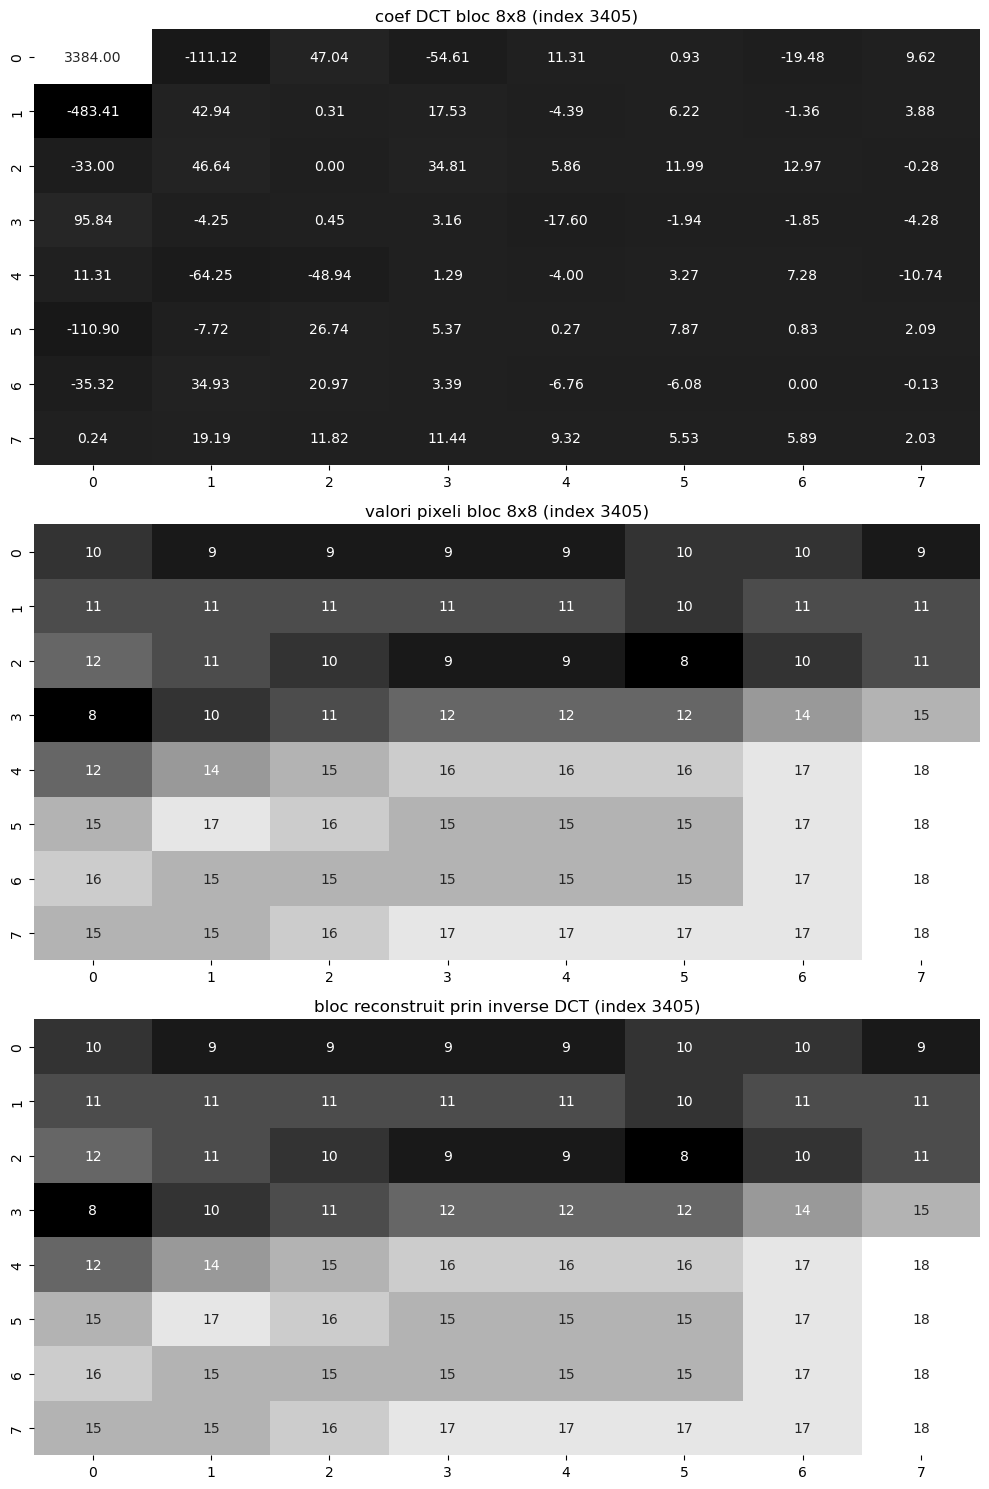

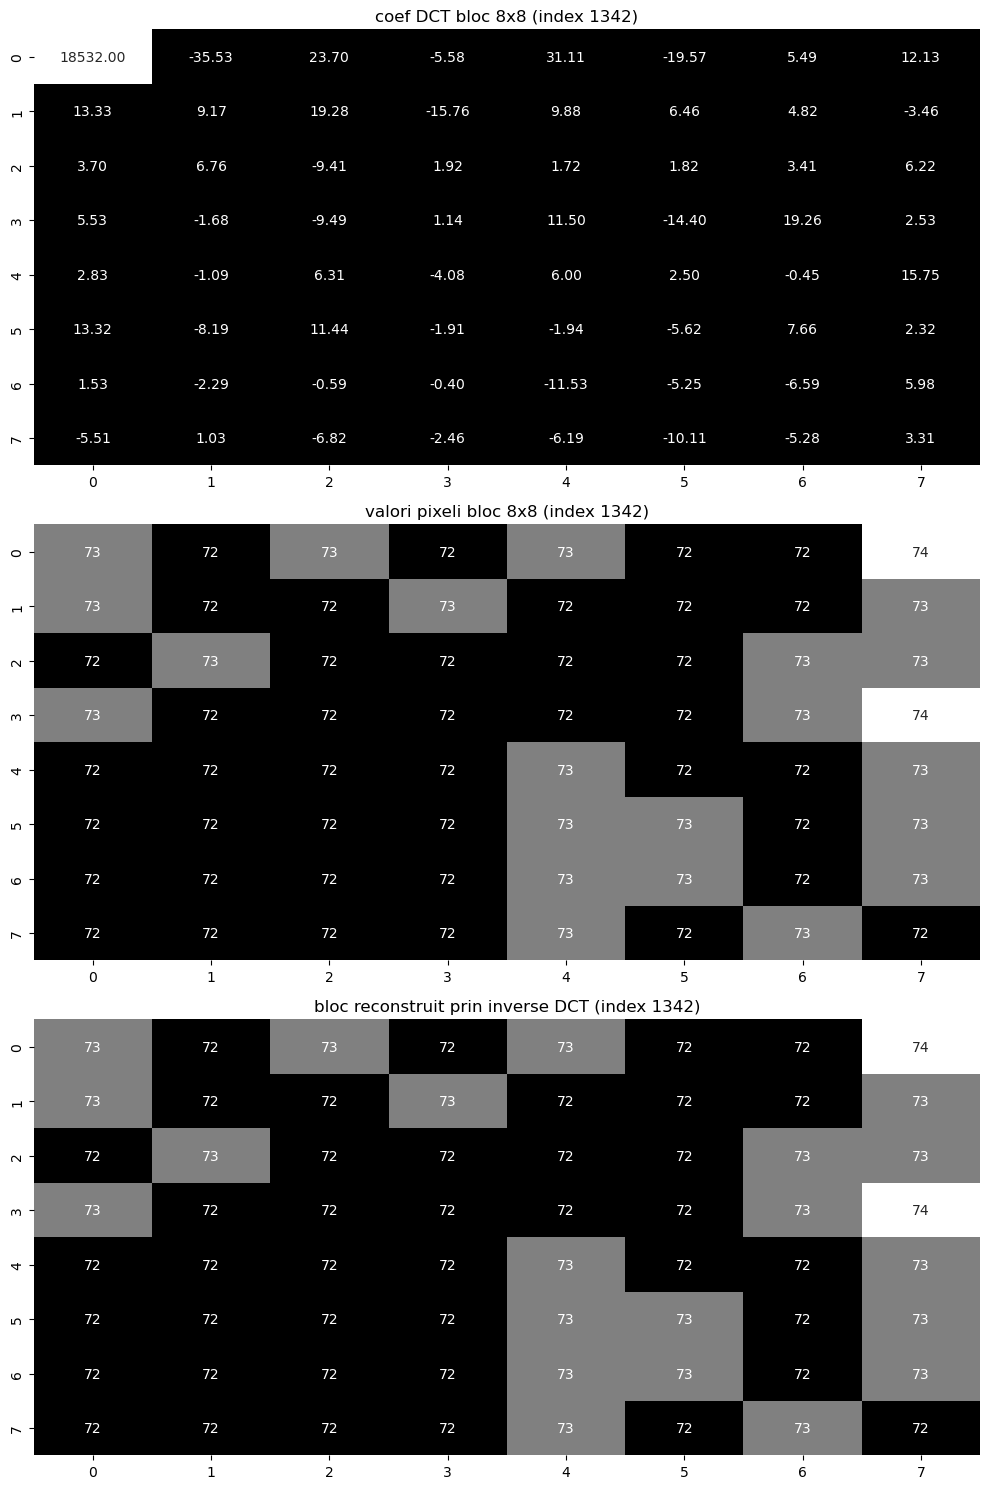

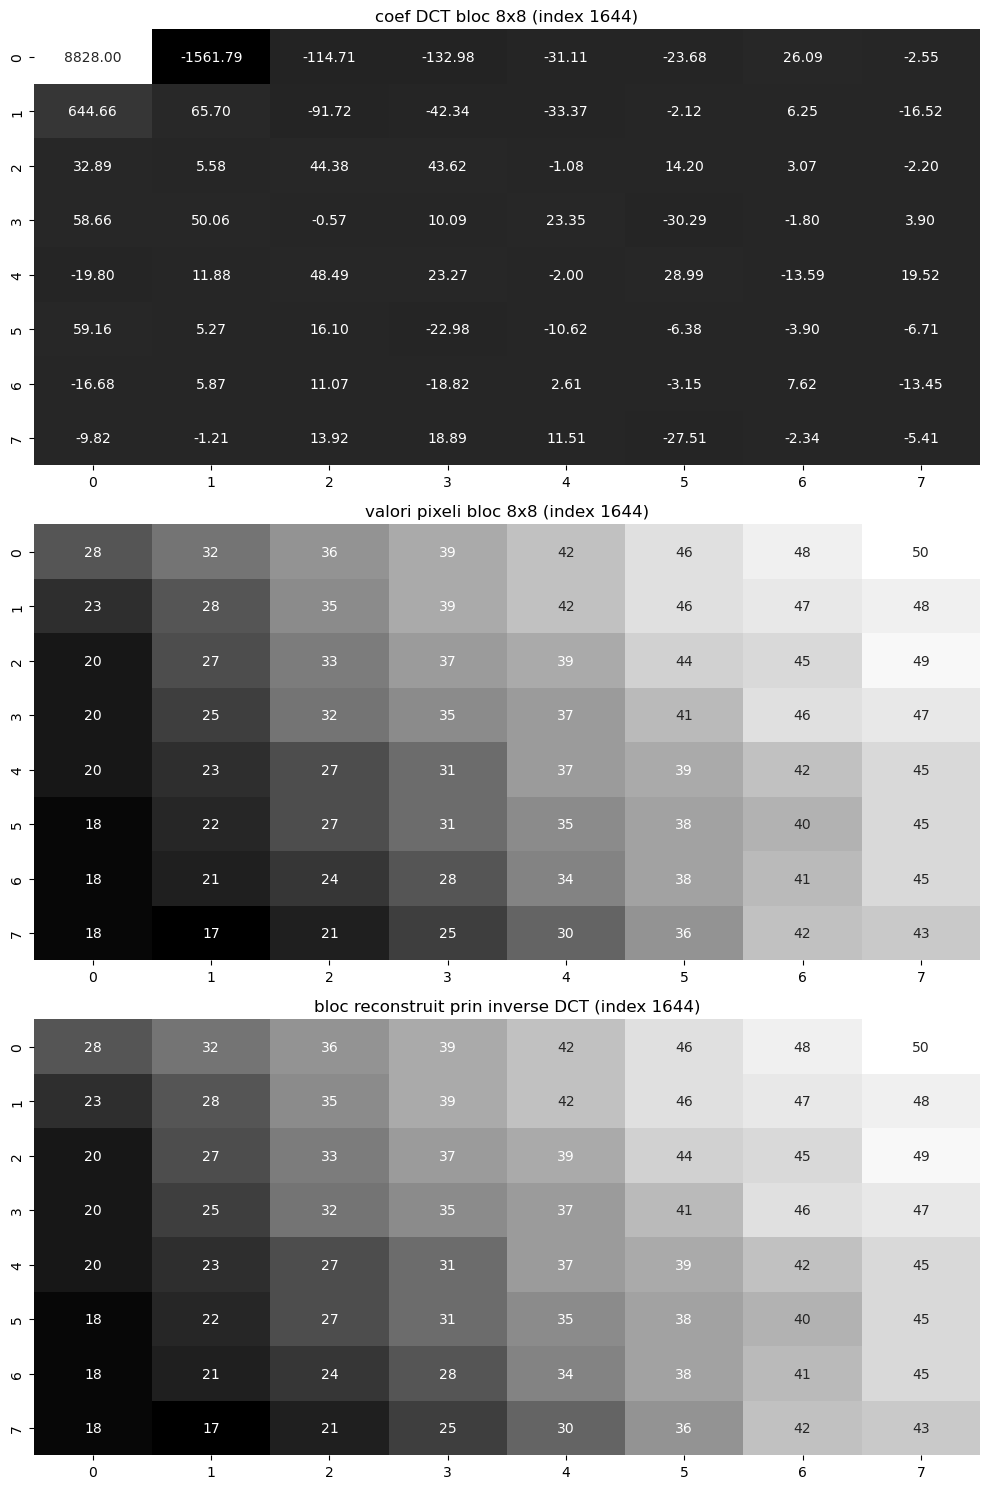

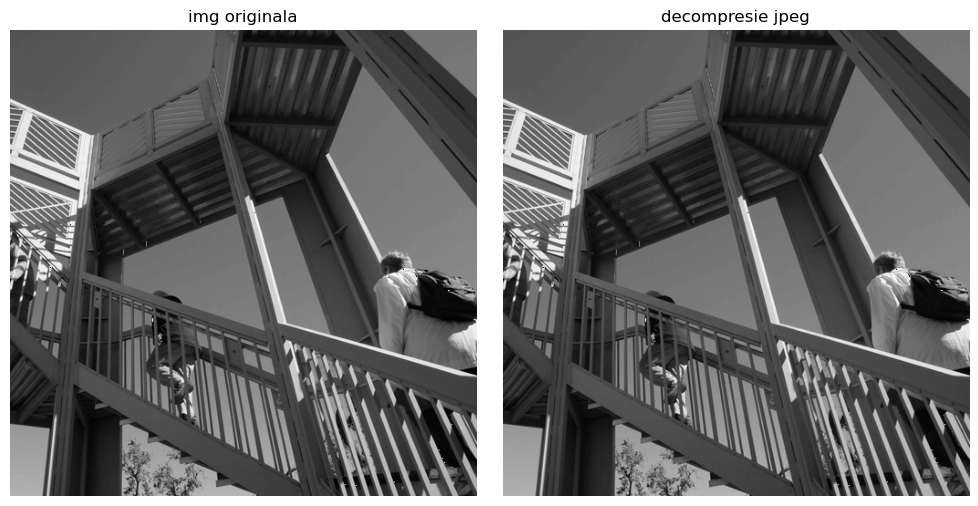

In [56]:
# discrete cosine transform
# cunoastem matricea de cuantizare jpeg Q_jpeg
# e o imagine monocroma (conversia spatiului de culoare nu are sens)
os.makedirs("./tema_jpeg/ex1", exist_ok=True)

def afis_bloc_dct(L_x, L_y, n=3):
    L_i = np.random.choice(len(L_x), size=n)
    for i in L_i:
        y = L_y[i]
        x = L_x[i]
        bloc_reconstruit = idctn(y)

        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        sns.heatmap(y, annot=True, fmt='.2f', cmap='gray', ax=axs[0], cbar=False)
        axs[0].set_title(f'coef DCT bloc 8x8 (index {i})')
        sns.heatmap(x, annot=True, cmap='gray', ax=axs[1], cbar=False)
        axs[1].set_title(f'valori pixeli bloc 8x8 (index {i})')
        sns.heatmap(bloc_reconstruit, annot=True, cmap='gray', ax=axs[2], cbar=False)
        axs[2].set_title(f'bloc reconstruit prin inverse DCT (index {i})')
        plt.tight_layout()
        plt.show()

L_x_bloc = []
L_y_dct = []
def jpeg_decompresie(img):
    global L_x_bloc, L_y_dct
    h, w = img.shape
    h_trunc = h-(h%8) # prin scaderea restului impartirii la 8 se obt dimensiunea trunchiata la cel mai apropiat multiplu de 8
    w_trunc = w-(w%8)
    img_trunc = img[:h_trunc, :w_trunc]
    out = np.zeros_like(img_trunc, dtype=np.float32)
    for i in range(0, h_trunc, 8):
        for j in range(0, w_trunc, 8):
            x = img_trunc[i:i+8, j:j+8]
            y = dctn(x) # 2d dct per bloc 8x8, coef care pot fi cuantizati
            L_x_bloc.append(x)
            L_y_dct.append(y)

            y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
            x_jpeg = idctn(y_jpeg) # inverse dct
            out[i:i+8, j:j+8] = x_jpeg
    
    afis_bloc_dct(L_x_bloc, L_y_dct)
    return out[:h, :w]

jpeg_img = jpeg_decompresie(X)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X, cmap=plt.cm.gray)
axs[0].set_title('img originala')
axs[0].axis('off')

axs[1].imshow(jpeg_img, cmap=plt.cm.gray)
axs[1].set_title('decompresie jpeg')
axs[1].axis('off')

plt.tight_layout()
plt.savefig(f"tema_jpeg/ex1/jpeg_compresie_decompresie.pdf", format="pdf")
plt.show()

Ex2

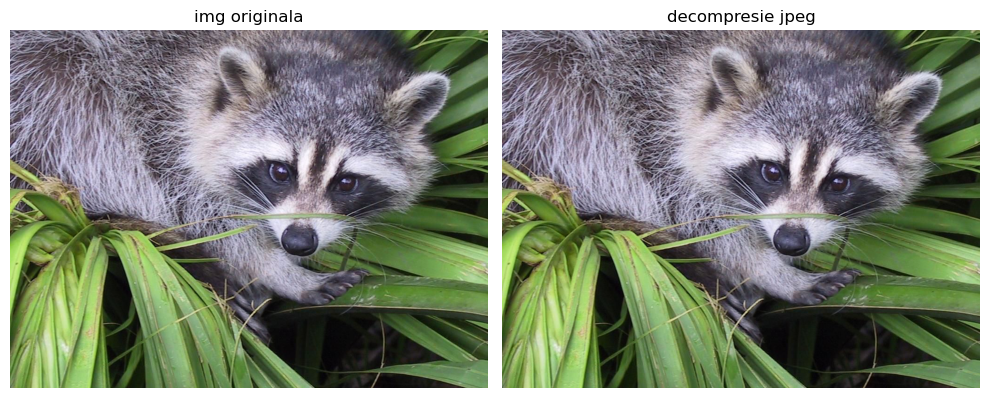

In [57]:
os.makedirs("./tema_jpeg/ex2", exist_ok=True)

def jpeg_decompresie_ycbcr(img):
    img_ycbcr = rgb2ycbcr(img) # conversie ycbcr
    h, w, _ = img_ycbcr.shape
    h_trunc = h-(h%8) # prin scaderea restului impartirii la 8 se obt dimensiunea trunchiata la cel mai apropiat multiplu de 8
    w_trunc = w-(w%8)
    img_ycbcr_trunc = img_ycbcr[:h_trunc, :w_trunc]
    L_canale_out = [] # lista de canale out reconstruite
    for k in range(3): # 3 canale Y, Cb, Cr
        img_canal_trunc = img_ycbcr_trunc[:, :, k]
        out = np.zeros_like(img_canal_trunc, dtype=np.float32)
        for i in range(0, h_trunc, 8):
            for j in range(0, w_trunc, 8):
                x = img_canal_trunc[i:i+8, j:j+8]
                y = dctn(x) # 2d dct per bloc 8x8, coef care pot fi cuantizati
                y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
                x_jpeg = idctn(y_jpeg) # inverse dct
                out[i:i+8, j:j+8] = x_jpeg
        L_canale_out.append(out)
    
    img_recon_ycbcr = np.stack(L_canale_out, axis=2) # array 3d format din matrici 2d ce reprez canalele
    img_recon_rgb = ycbcr2rgb(img_recon_ycbcr) # conversie rgb
    img_recon_rgb = np.clip(img_recon_rgb, 0, 255).astype(np.uint8) # range valid

    return img_recon_rgb

img = datasets.face().astype(np.float32) # img raton
jpeg_img = jpeg_decompresie_ycbcr(img)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img.astype(np.uint8))
axs[0].set_title('img originala')
axs[0].axis('off')

axs[1].imshow(jpeg_img)
axs[1].set_title('decompresie jpeg')
axs[1].axis('off')

plt.tight_layout()
plt.savefig(f"tema_jpeg/ex2/jpeg_compresie_decompresie_ycbcr.pdf", format="pdf")
plt.show()

Ex3 - am primit brain damage pentru ca orice mse de valori mici nu va fi vizibil ca si modificari in imaginea decompressed no matter what

factor curent: 35000.00, mse curent: 4359094.00
factor curent: 35022.22, mse curent: 4360159.50
factor curent: 35044.44, mse curent: 4361222.50
factor curent: 35066.67, mse curent: 4362201.00
factor curent: 35088.89, mse curent: 4363072.50
factor curent: 35111.11, mse curent: 4363901.00
factor curent: 35133.33, mse curent: 4364685.00
factor curent: 35155.56, mse curent: 4365475.50
factor curent: 35177.78, mse curent: 4366335.00
factor curent: 35200.00, mse curent: 4367277.50
factor final: 35088.89, mse final: 4363072.50, mse threshold: 4363000


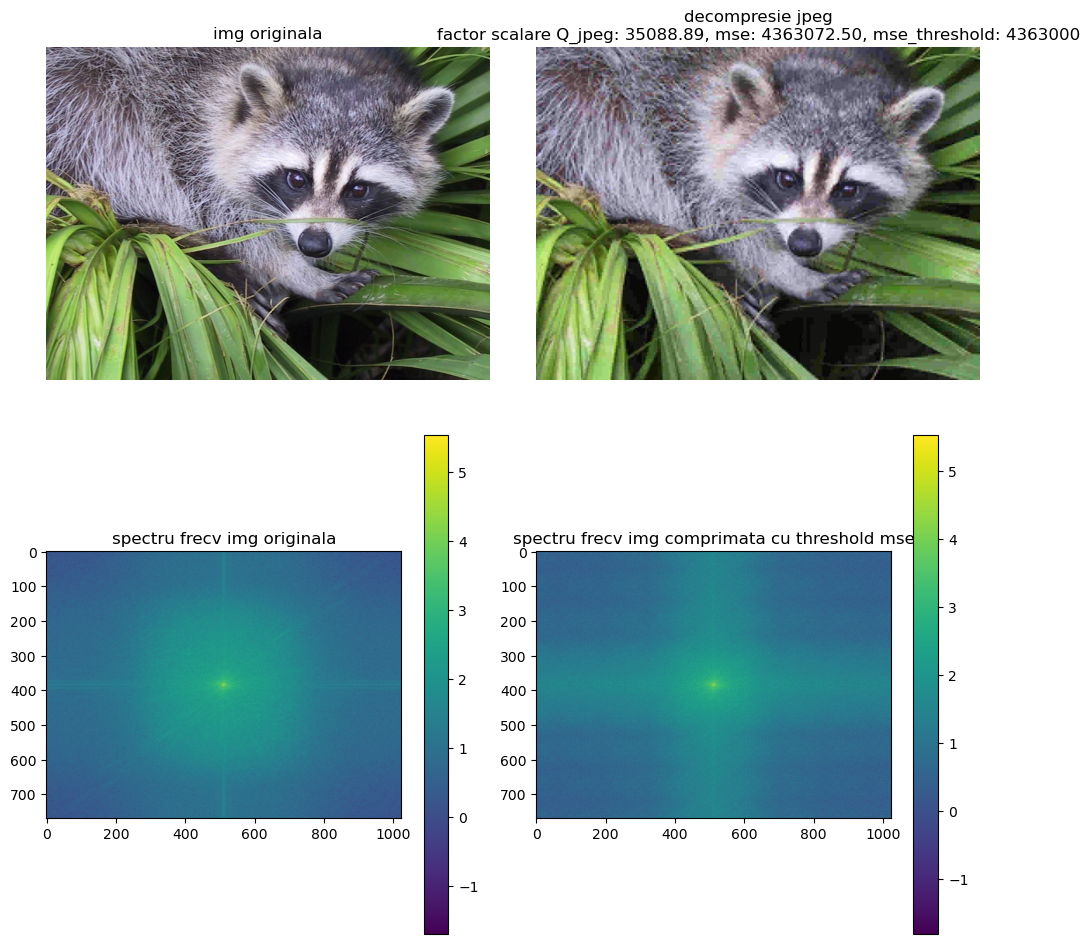

In [58]:
# nefiind specificat dar numai sugerat in lab sa filtram frecv, am ales atat sa modific Q_jpeg prin scalarea lui, dar si sa elimin frecv cu fiecare bloc 8x8 procesat
os.makedirs("./tema_jpeg/ex3", exist_ok=True)

def jpeg_mse_threshold(img, mse_threshold, factor_init, factor_fin, factor_rata): # factor mai mare va duce la o compresie mai dura
    mse = float('inf')
    L_factor_mse_ycbcr = [] # lista de tupluri cu factorul, mse-ul si img reconstruita ycbcr corespunzatoare acelui factor
    img_ycbcr = rgb2ycbcr(img) # conversie ycbcr
    h, w, _ = img_ycbcr.shape
    h_trunc = h-(h%8) # prin scaderea restului impartirii la 8 se obt dimensiunea trunchiata la cel mai apropiat multiplu de 8
    w_trunc = w-(w%8)
    img_ycbcr_trunc = img_ycbcr[:h_trunc, :w_trunc]
    for factor in np.linspace(factor_init, factor_fin, factor_rata):
        L_canale_out = [] # lista de canale out reconstruite
        Q = Q_jpeg*factor # prin alterarea lui Q_jpeg ma astept ca si coef dct pentru fiecare bloc de canal 8x8 sa difere (toate val fiind scalate)
        for k in range(3): # 3 canale Y, Cb, Cr
            img_canal_trunc = img_ycbcr_trunc[:, :, k]
            out = np.zeros_like(img_canal_trunc, dtype=np.float32)
            for i in range(0, h_trunc, 8):
                for j in range(0, w_trunc, 8):
                    x = img_canal_trunc[i:i+8, j:j+8]
                    y = dctn(x) # 2d dct per bloc 8x8, coef care pot fi cuantizati
                    y_jpeg = Q*np.round(y/Q)

                    # partea de eliminare de frecv care vizibil fac o diferenta
                    # pastreaza doar patratul din stg sus de dim 2x2
                    y_ziped = y_jpeg.copy()
                    y_ziped[2:, :] = 0
                    y_ziped[:, 2:] = 0

                    x_jpeg = idctn(y_ziped) # inverse dct pe y_ziped
                    out[i:i+8, j:j+8] = x_jpeg
            L_canale_out.append(out)
    
        img_recon_ycbcr = np.stack(L_canale_out, axis=2) # array 3d format din matrici 2d ce reprez canalele
        mse = np.mean((img_ycbcr_trunc-img_recon_ycbcr)**2)
        L_factor_mse_ycbcr.append((factor, mse, img_recon_ycbcr))

        print(f"factor curent: {factor:.2f}, mse curent: {mse:.2f}")
        
    best_factor, best_mse, best_ycbcr = min(L_factor_mse_ycbcr, key=lambda x: abs(x[1]-mse_threshold)) # cel mai bun factor e cel care da mse cel mai apropiat de prag

    img_recon_rgb = ycbcr2rgb(best_ycbcr) # conversie rgb
    img_recon_rgb = np.clip(img_recon_rgb, 0, 255).astype(np.uint8) # range valid

    print(f"factor final: {best_factor:.2f}, mse final: {best_mse:.2f}, mse threshold: {mse_threshold}")
    return best_factor, best_mse, img_recon_rgb

Q_jpeg = np.array(Q_jpeg, dtype=np.float32)
img = datasets.face().astype(np.float32) # img raton
threshold = 4363000
factor, mse, jpeg_img = jpeg_mse_threshold(img, threshold, 35000, 35200, 10)

# plot inspirat din lab7 pentru a ilustra spectrele diferite ale imaginilor
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img.astype(np.uint8))
axs[0, 0].set_title('img originala')
axs[0, 0].axis('off')

axs[0, 1].imshow(jpeg_img)
axs[0, 1].set_title(f"decompresie jpeg\nfactor scalare Q_jpeg: {factor:.2f}, mse: {mse:.2f}, mse_threshold: {threshold}")
axs[0, 1].axis('off')

fft_orig = np.fft.fft2(np.mean(img, axis=2)/255)
fft_comp = np.fft.fft2(np.mean(jpeg_img, axis=2)/255)
log_mag_orig = np.log10(np.abs(np.fft.fftshift(fft_orig))+1e-9)
log_mag_comp = np.log10(np.abs(np.fft.fftshift(fft_comp))+1e-9)

im1 = axs[1, 0].imshow(log_mag_orig, cmap='viridis')
axs[1, 0].set_title('spectru frecv img originala')
plt.colorbar(im1, ax=axs[1, 0])

im2 = axs[1, 1].imshow(log_mag_comp, cmap='viridis')
axs[1, 1].set_title('spectru frecv img comprimata cu threshold mse')
plt.colorbar(im2, ax=axs[1, 1])

plt.tight_layout()
plt.savefig(f"tema_jpeg/ex3/jpeg_compresie_decompresie_mse_threshold.pdf", format="pdf")
plt.show()

Ex4

In [59]:
reader = imageio.get_reader('./tema_jpeg/cat.mp4')
writer = imageio.get_writer('./tema_jpeg/cat_compressed.mp4', fps=reader.get_meta_data()['fps']) # fara al doilea parametru, videoclipul e incetinit

for frame in reader:
    frame_rgb = frame.astype(np.float32)
    threshold = 950000
    _, _, jpeg_img = jpeg_mse_threshold(frame_rgb, threshold, 35000, 35200, 5) # tot un rezultat uint8 in intervalul 0, 255
    # plt.imshow(jpeg_img)
    # plt.show()
    writer.append_data(jpeg_img)

writer.close()
reader.close()

factor curent: 35000.00, mse curent: 1033362.81
factor curent: 35050.00, mse curent: 1035152.06
factor curent: 35100.00, mse curent: 1037058.38
factor curent: 35150.00, mse curent: 1038927.38
factor curent: 35200.00, mse curent: 1040501.50
factor final: 35000.00, mse final: 1033362.81, mse threshold: 950000
factor curent: 35000.00, mse curent: 977564.56
factor curent: 35050.00, mse curent: 979028.94
factor curent: 35100.00, mse curent: 980814.44
factor curent: 35150.00, mse curent: 982640.38
factor curent: 35200.00, mse curent: 984373.25
factor final: 35000.00, mse final: 977564.56, mse threshold: 950000
factor curent: 35000.00, mse curent: 984829.75
factor curent: 35050.00, mse curent: 986622.12
factor curent: 35100.00, mse curent: 988450.56
factor curent: 35150.00, mse curent: 990511.56
factor curent: 35200.00, mse curent: 992135.75
factor final: 35000.00, mse final: 984829.75, mse threshold: 950000
factor curent: 35000.00, mse curent: 1000713.69
factor curent: 35050.00, mse curent: 